In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import gzip
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
from nfp.preprocessing.crystal_preprocessor import PymatgenPreprocessor
from pymatgen import Structure
from tqdm.auto import tqdm

tqdm.pandas()

structure_dir = Path("/projects/rlmolecule/jlaw/inputs/structures")
inputs_dir = Path("/projects/rlmolecule/pstjohn/crystal_inputs/")
volrelax_dir = Path("/projects/rlmolecule/pstjohn/volume_relaxation_outputs/")

# batt_energy_file = Path(inputs_dir, "20211223_deduped_energies_matminer_0.01.csv")
vol_energy_file = Path(volrelax_dir, "20220504_volume_relaxed_energy.csv.gz")
# icsd_energy_file = Path(structure_dir, "icsd/icsd_energies.csv")

vol_energy = pd.read_csv(vol_energy_file)
# batt_energy = pd.read_csv(Path(batt_energy_file))
# icsd_energy = pd.read_csv(icsd_energy_file)

data = pd.read_pickle(Path(inputs_dir, "20220511_scaled_inputs.p"))
data['type'] = data.type.astype('category')
max_distance = data['inputs'].apply(lambda x: x['distance'].max())
data = data[max_distance < 100]  # drop some problematic icsd structures

In [3]:
vol_energy['hit_upper_bound'] = vol_energy.volume > (vol_energy.dls_volume * 1.95 - 1)

to_drop = data[(data.type == 'vol') & data.id.isin(vol_energy[vol_energy['hit_upper_bound']].id)]
data['hit_upper_bound'] = data.index.isin(to_drop.index)

In [4]:
data.head()

,id,type,composition,energyperatom,volume,num_sites,inputs,scale_factor,radii_scale_factor,hit_upper_bound
0,icsd_085777,icsd,La1O1P1Zn1,-5.833295,145.053230,8,"{'site': [57, 57, 30, 30, 15, 15, 8, 8], 'dist...",0.422622,0.392157,False
1,icsd_173786,icsd,I3Ti1,-3.397267,287.551744,8,"{'site': [22, 22, 53, 53, 53, 53, 53, 53], 'di...",0.358616,0.357143,False
2,icsd_056827,icsd,Al2O12W3,-8.063763,1024.266060,68,"{'site': [13, 13, 13, 13, 13, 13, 13, 13, 74, ...",0.585426,0.512821,False
3,icsd_078912,icsd,Cl9Sb1Se1,-2.729116,1208.211653,44,"{'site': [51, 51, 51, 51, 34, 34, 34, 34, 17, ...",0.472882,0.449266,False
4,icsd_076029,icsd,P1W1,-7.874002,115.123926,8,"{'site': [15, 15, 15, 15, 74, 74, 74, 74], 'di...",0.424328,0.425532,False


In [5]:
data.type.unique()

['icsd', 'vol', 'relax']
Categories (3, object): ['icsd', 'relax', 'vol']

In [6]:
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element

In [7]:
composition = data.composition.progress_apply(lambda x: pd.Series(Composition(x).as_dict())).fillna(0.)

  0%|          | 0/145183 [00:00<?, ?it/s]

In [8]:
X = composition[data.type.isin(['icsd', 'relax'])].values
y = data[data.type.isin(['icsd', 'relax'])].energyperatom.values * X.sum(1)

In [9]:
from sklearn.linear_model import HuberRegressor

reg = HuberRegressor(max_iter=1000)
reg.fit(X, y)

HuberRegressor(max_iter=1000)

In [10]:
data['volperatom'] = data['volume'] / data['num_sites']
y_vol = data[data.type.isin(['icsd', 'relax'])].volperatom.values * X.sum(1)

reg_vol = HuberRegressor(max_iter=1000)
reg_vol.fit(X, y_vol)

HuberRegressor(max_iter=1000)

In [11]:
## calculate predicted energies from linear model

data['reg_energyperatom'] = reg.predict(composition) / composition.sum(1)
data['reg_volperatom'] = reg_vol.predict(composition) / composition.sum(1)

In [12]:
## calculate predicted volume from atomic radii

pred_volume = data['volume'] * (data['scale_factor'] / data['radii_scale_factor']) ** 3

data['radii_volperatom'] = pred_volume / data['num_sites']

In [13]:
data['residual_energy'] = data['energyperatom'] - data['reg_energyperatom']
data['residual_volume'] = data['volperatom'] - data['reg_volperatom']

In [14]:
energy_outliers = (data.residual_energy < -2) | (data.residual_energy > 6)
volume_outliers = (data.residual_volume < -20) | (data.residual_volume > 20)

In [15]:
(energy_outliers | volume_outliers).sum()

1677

In [16]:
data_subset = data[~(energy_outliers | volume_outliers)]

In [17]:
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

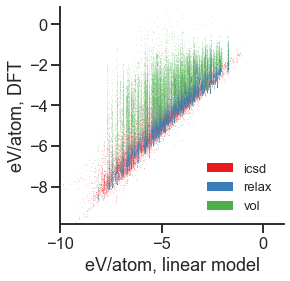

In [18]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

artist = dsshow(data_subset[~data_subset.hit_upper_bound],
       ds.Point('reg_energyperatom', 'energyperatom'),
       ds.count_cat('type'),       
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(-10, 1), y_range=(-10, 1), ax=ax)

ax.set_xlabel('eV/atom, linear model')
ax.set_ylabel('eV/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()

(-2.0, 6.0)

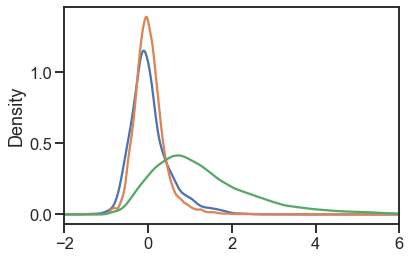

In [19]:
data_subset[data_subset.type == 'icsd'].residual_energy.plot.kde()
data_subset[data_subset.type == 'relax'].residual_energy.plot.kde()
data_subset[data_subset.type == 'vol'].residual_energy.plot.kde()

plt.xlim([-2, 6])

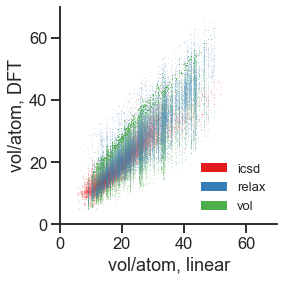

In [20]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

artist = dsshow(data_subset[~data_subset.hit_upper_bound],
       ds.Point('reg_volperatom', 'volperatom'),
       ds.count_cat('type'),
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(0, 70), y_range=(0, 70), ax=ax)

ax.set_xlabel('vol/atom, linear')
ax.set_ylabel('vol/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()

(-20.0, 20.0)

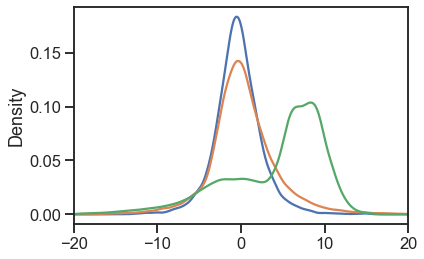

In [21]:
data_subset[data_subset.type == 'icsd'].residual_volume.plot.kde()
data_subset[data_subset.type == 'relax'].residual_volume.plot.kde()
data_subset[data_subset.type == 'vol'].residual_volume.plot.kde()

plt.xlim([-20, 20])

In [ ]:
data_trimmed = data_subset[['id', 'type', 'composition', 'num_sites', 'inputs', 'hit_upper_bound', 'energyperatom', 'volperatom']]
data_trimmed.to_pickle(Path(inputs_dir, "20220512_outliers_removed.p"))

In [40]:
from collections import Counter
train = data_trimmed.head(100)

site_counts = train.inputs.progress_apply(
    lambda x: pd.Series(Counter(x["site"]))
).reindex(columns=np.arange(84)).fillna(0)
# Linear regression assumes a sum, while we average over sites in the neural network
# Here, we make the regression target the total energy, not the site-averaged energy
num_sites = site_counts.sum(1)
total_energies = train["energyperatom"] * num_sites

# Do the least-squares regression, and stack on zeros for the mask and unknown
# tokens
output_bias = np.linalg.lstsq(site_counts, total_energies, rcond=None)[0]
# output_bias = np.hstack([np.zeros(2), output_bias])

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
output_bias.shape

(84,)

In [39]:
site_counts.fillna(0.)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
output_bias

array([ -5.35750456,  -6.08812207,  -8.92347611,  -6.49089572,
        -5.64321464,  -7.29717971,  -5.29979938,  -3.53268252,
        -3.39409352,  -8.51948119,  -9.46921812,  -5.81003376,
        -4.90896679,  -2.68182387,  -2.20324327,  -5.58521012,
        -9.97260714,  -9.46572641,  -8.12757281,  -7.36447364,
        -8.95045268,  -6.7314732 ,  -5.26809734,  -3.9755502 ,
        -2.05682605,   0.58567696,  -3.2333358 ,  -3.9401191 ,
        -5.07645212,  -3.71056671,  -1.77224407,  -7.75040384,
        -6.51861401,  -5.95031833,  -8.30650208,  -4.44171574,
        -4.41733091,  -1.49116769,   0.28079328,  -2.09739489,
        -1.73689523,  -5.0062641 ,  -0.9390466 ,  -2.22614363,
        -2.99839046,  -6.44046433,  -9.14707801, -11.77428739,
       -10.83994   ,  -5.37771433,  -2.83945391,  -0.01427286,
         1.54436815,   3.11398777,  -3.38160567,  -4.19460295])